# Start of the Project
Importing Libraries and Data
Creating Essential DataFrames
Defining Feature Engineering Functions

In [189]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
#import matplotlib

pd.set_option('display.max_columns', None)

# Assuming the CSV files are in the same directory as your Python script or Jupyter Notebook

# Import Game data
games_data = pd.read_csv('nfl-big-data-bowl-2024/games.csv')

# Import Play data
plays_data = pd.read_csv('nfl-big-data-bowl-2024/plays.csv')

# Import Player data
players_data = pd.read_csv('nfl-big-data-bowl-2024/players.csv')

# Import Tackles data
tackles_data = pd.read_csv('nfl-big-data-bowl-2024/tackles.csv')

tracking_data_1 = pd.read_csv(f'nfl-big-data-bowl-2024/tracking_week_1.csv')

# Example for importing all weeks of Tracking data
# Adjust the range based on the actual weeks in your dataset
tracking_data_all_weeks = pd.concat([pd.read_csv(f'nfl-big-data-bowl-2024/tracking_week_{week}.csv') for week in range(1, 10)])

# Now you can use these DataFrames in your analysis

In [176]:
def calculate_average_speed(tracking_data, nflId):
    # Filter tracking data for the specific player
    player_tracking = tracking_data[tracking_data['nflId'] == nflId]
    average_speed = player_tracking['s'].sum() / len(player_tracking['s'])
    return average_speed

# Example usage:
# Assuming you have loaded the tracking data into a DataFrame named 'tracking_data'
# and the player data into a DataFrame named 'player_data'

# Replace 'your_nflId_here' with the actual nflId of the player you want to calculate the average speed for
nflId_to_calculate = 29550	  

average_speed = calculate_average_speed(tracking_data_all_weeks, nflId_to_calculate)
average_speed_min = average_speed * 60
print(f"Average speed for player with nflId {nflId_to_calculate}: {average_speed} yards/second")
print(f"Average speed for player with nflId {nflId_to_calculate}: {average_speed_min} yards/minute")

def calculate_normalized_aggression_score(tackles_data, nflId):
    # Filter tackles data for the specific player
    player_tackles = tackles_data[tackles_data['nflId'] == nflId]

    if len(player_tackles) == 0:
        #print(f"Player with nflId {nflId} not found in the tackles data.") 
        return 0

    # Calculate normalized aggression score based on tackles, assisted tackles, forced fumbles, and missed tackles
    tackles = player_tackles['tackle'].sum()
    assisted_tackles = player_tackles['assist'].sum()
    forced_fumbles = player_tackles['forcedFumble'].sum()
    missed_tackles = player_tackles['pff_missedTackle'].sum()

    # Define a formula for the normalized aggression score (you can adjust the weights as needed)
    aggression_score = (tackles + assisted_tackles + forced_fumbles -
                        missed_tackles) / max(1, len(player_tackles))

    return aggression_score


# Example usage:
# Assuming you have loaded the tackles data into a DataFrame named 'tackles_data'

# Replace 'your_nflId_here' with the actual nflId of the player you want to calculate the normalized aggression score for
nflId_to_calculate_aggression_score = 29550

player_aggression_score = calculate_normalized_aggression_score(
    tackles_data, nflId_to_calculate_aggression_score)
if player_aggression_score is not None:
    print(
        f"Normalized Aggression Score for player with nflId {nflId_to_calculate_aggression_score}: {player_aggression_score:.2f}"
    )

def calculate_bmi(player_data, nflId):
    # Filter player data for the specific player
    player_info = player_data[player_data['nflId'] == nflId]

    if len(player_info) == 0:
        print(f"Player with nflId {nflId} not found.")
        return None

    # Extract weight and height
    weight_kg = player_info['weight'].values[0] * 0.453592  # Convert pounds to kilograms
    height_meters = convert_height_to_meters(player_info['height'].values[0])  # Convert feet and inches to meters

    # Calculate BMI
    bmi = weight_kg / (height_meters ** 2)

    return bmi

def convert_height_to_meters(height):
    # Convert height from feet and inches to meters
    feet, inches = map(int, height.split('-'))
    height_meters = (feet * 12 + inches) * 0.0254  # 1 foot = 12 inches, 1 inch = 0.0254 meters
    return height_meters

# Example usage:
# Assuming you have loaded the player data into a DataFrame named 'player_data'

# Replace 'your_nflId_here' with the actual nflId of the player you want to calculate the BMI for
nflId_to_calculate_bmi = 29550  

player_bmi = calculate_bmi(players_data, nflId_to_calculate_bmi)
if player_bmi is not None:
    print(f"BMI for player with nflId {nflId_to_calculate_bmi}: {player_bmi:.2f}")

Average speed for player with nflId 29550: 2.399963427377221 yards/second
Average speed for player with nflId 29550: 143.99780564263324 yards/minute
Normalized Aggression Score for player with nflId 29550: 0.00
BMI for player with nflId 29550: 39.92


# Category Rules
i. No category should contain  less than 50 samples
ii. Categories can merge if it is on the same team and if roles are similar
iii. Offensive and Defensive categories should be balanced in number and equivalence
iv. The resulting category name will generalize all members of the category

In [194]:
# grouping similar positions

modified_players_data = players_data.copy()

#Offensive Roles
#merging RB and FB
modified_players_data["position"]=np.where(modified_players_data["position"] == 'FB', 'RB', modified_players_data["position"])
#merging TE and LS
modified_players_data["position"]=np.where(modified_players_data["position"] == 'LS', 'TE', modified_players_data["position"])
#merging C and G
modified_players_data["position"]=np.where(modified_players_data["position"] == 'C', 'C-G', modified_players_data["position"])
modified_players_data["position"]=np.where(modified_players_data["position"] == 'G', 'C-G', modified_players_data["position"])

#Defensive Roles
#merging DB and CB 
modified_players_data["position"]=np.where(modified_players_data["position"] == 'DB', 'CB', modified_players_data["position"])
#merging DE and OLB
modified_players_data["position"]=np.where(modified_players_data["position"] == 'DE', 'DE-OLB', modified_players_data["position"])
modified_players_data["position"]=np.where(modified_players_data["position"] == 'OLB', 'DE-OLB', modified_players_data["position"])
#merging NT and DT 
modified_players_data["position"]=np.where(modified_players_data["position"] == 'NT', 'DT', modified_players_data["position"])
#merging SS and FS 
modified_players_data["position"]=np.where(modified_players_data["position"] == 'SS', 'S', modified_players_data["position"])
modified_players_data["position"]=np.where(modified_players_data["position"] == 'FS', 'S', modified_players_data["position"])
#merging ILB and MLB 
modified_players_data["position"]=np.where(modified_players_data["position"] == 'ILB', 'LB', modified_players_data["position"])
modified_players_data["position"]=np.where(modified_players_data["position"] == 'MLB', 'LB', modified_players_data["position"])


In [195]:
modified_players_data['position'].value_counts()

position
DE-OLB    265
WR        218
CB        192
DT        158
C-G       158
S         142
RB        138
TE        126
T         121
LB        104
QB         61
Name: count, dtype: int64

# Running the Model
Defining the Feature Table
Splitting into train and test datasets
Running the Decision Tree Classifier

In [196]:
feature_table = pd.DataFrame()
nflIds = modified_players_data["nflId"]

for id in nflIds:
    player_bmi = calculate_bmi(modified_players_data, id)
    player_aggression_score = calculate_normalized_aggression_score(tackles_data, id)
    average_speed = calculate_average_speed(tracking_data_all_weeks, id)
    passes_caught = count_passes_caught(plays_data, id)
    player_position_index = modified_players_data.index[modified_players_data["nflId"] == id]
    player_position = modified_players_data.at[player_position_index.values[0], 'position']
    new_data = pd.DataFrame(data={'nflId': [id],'BMI': [player_bmi],'Average Speed': [player_aggression_score],'Aggression Score': [player_aggression_score],'Passes Caught': [passes_caught],'Position': [player_position]})
    # Concatenate the existing data with the new table
    feature_table = pd.concat([feature_table, new_data], ignore_index=True)

# Display the updated table
feature_table 


,nflId,BMI,Average Speed,Aggression Score,Passes Caught,Position
0,25511,27.387557,0.0,0.0,0,QB
1,29550,39.924971,0.0,0.0,0,T
2,29851,28.887970,0.0,0.0,0,QB
3,30842,30.854606,0.0,0.0,1,TE
4,33084,26.413777,0.0,0.0,0,QB
...,...,...,...,...,...,...
1678,55200,30.739046,1.0,1.0,0,DT
1679,55212,31.193262,0.0,0.0,0,LB
1680,55239,38.517294,1.0,1.0,0,DT
1681,55240,24.407537,1.0,1.0,0,CB


In [197]:

# Define features (X) and target variable (y)
features = feature_table[['BMI', 'Average Speed', 'Aggression Score', 'Passes Caught']] 
target = feature_table['Position'] 

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the decision tree classifier
classifier = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42)

# Train the model
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Display Precision Score
print("Precision Score:")
print(precision_score(y_test, y_pred, average='macro'))

# Display Recall Score
print("Recall Score:")
print(recall_score(y_test, y_pred,average='macro'))

# Display Feature Importances
feature_importance = pd.DataFrame(classifier.feature_importances_ , index=features.columns).sort_values
print(feature_importance)

Accuracy: 0.56
Classification Report:
              precision    recall  f1-score   support

         C-G       0.56      1.00      0.72        31
          CB       0.55      0.62      0.58        37
      DE-OLB       0.61      0.74      0.67        50
          DT       0.89      0.78      0.83        32
          LB       1.00      0.05      0.09        21
          QB       0.55      0.43      0.48        14
          RB       0.12      0.12      0.12        26
           S       0.35      0.28      0.31        29
           T       0.00      0.00      0.00        21
          TE       0.47      0.47      0.47        34
          WR       0.67      0.90      0.77        42

    accuracy                           0.56       337
   macro avg       0.52      0.49      0.46       337
weighted avg       0.54      0.56      0.51       337

Confusion Matrix:
[[31  0  0  0  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  2  0 10  0  0  2]
 [ 1  1 37  3  0  0  5  3  0  0  0]
 [ 2  0  5 25  0  0  0 

/Users/smithsonarrey/miniconda3/envs/nfl_player_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/smithsonarrey/miniconda3/envs/nfl_player_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/smithsonarrey/miniconda3/envs/nfl_player_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

# Plotting the Results

array([[<Axes: title={'center': 'nflId'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'Average Speed'}>,
        <Axes: title={'center': 'Aggression Score'}>],
       [<Axes: title={'center': 'Passes Caught'}>, <Axes: >]],
      dtype=object)

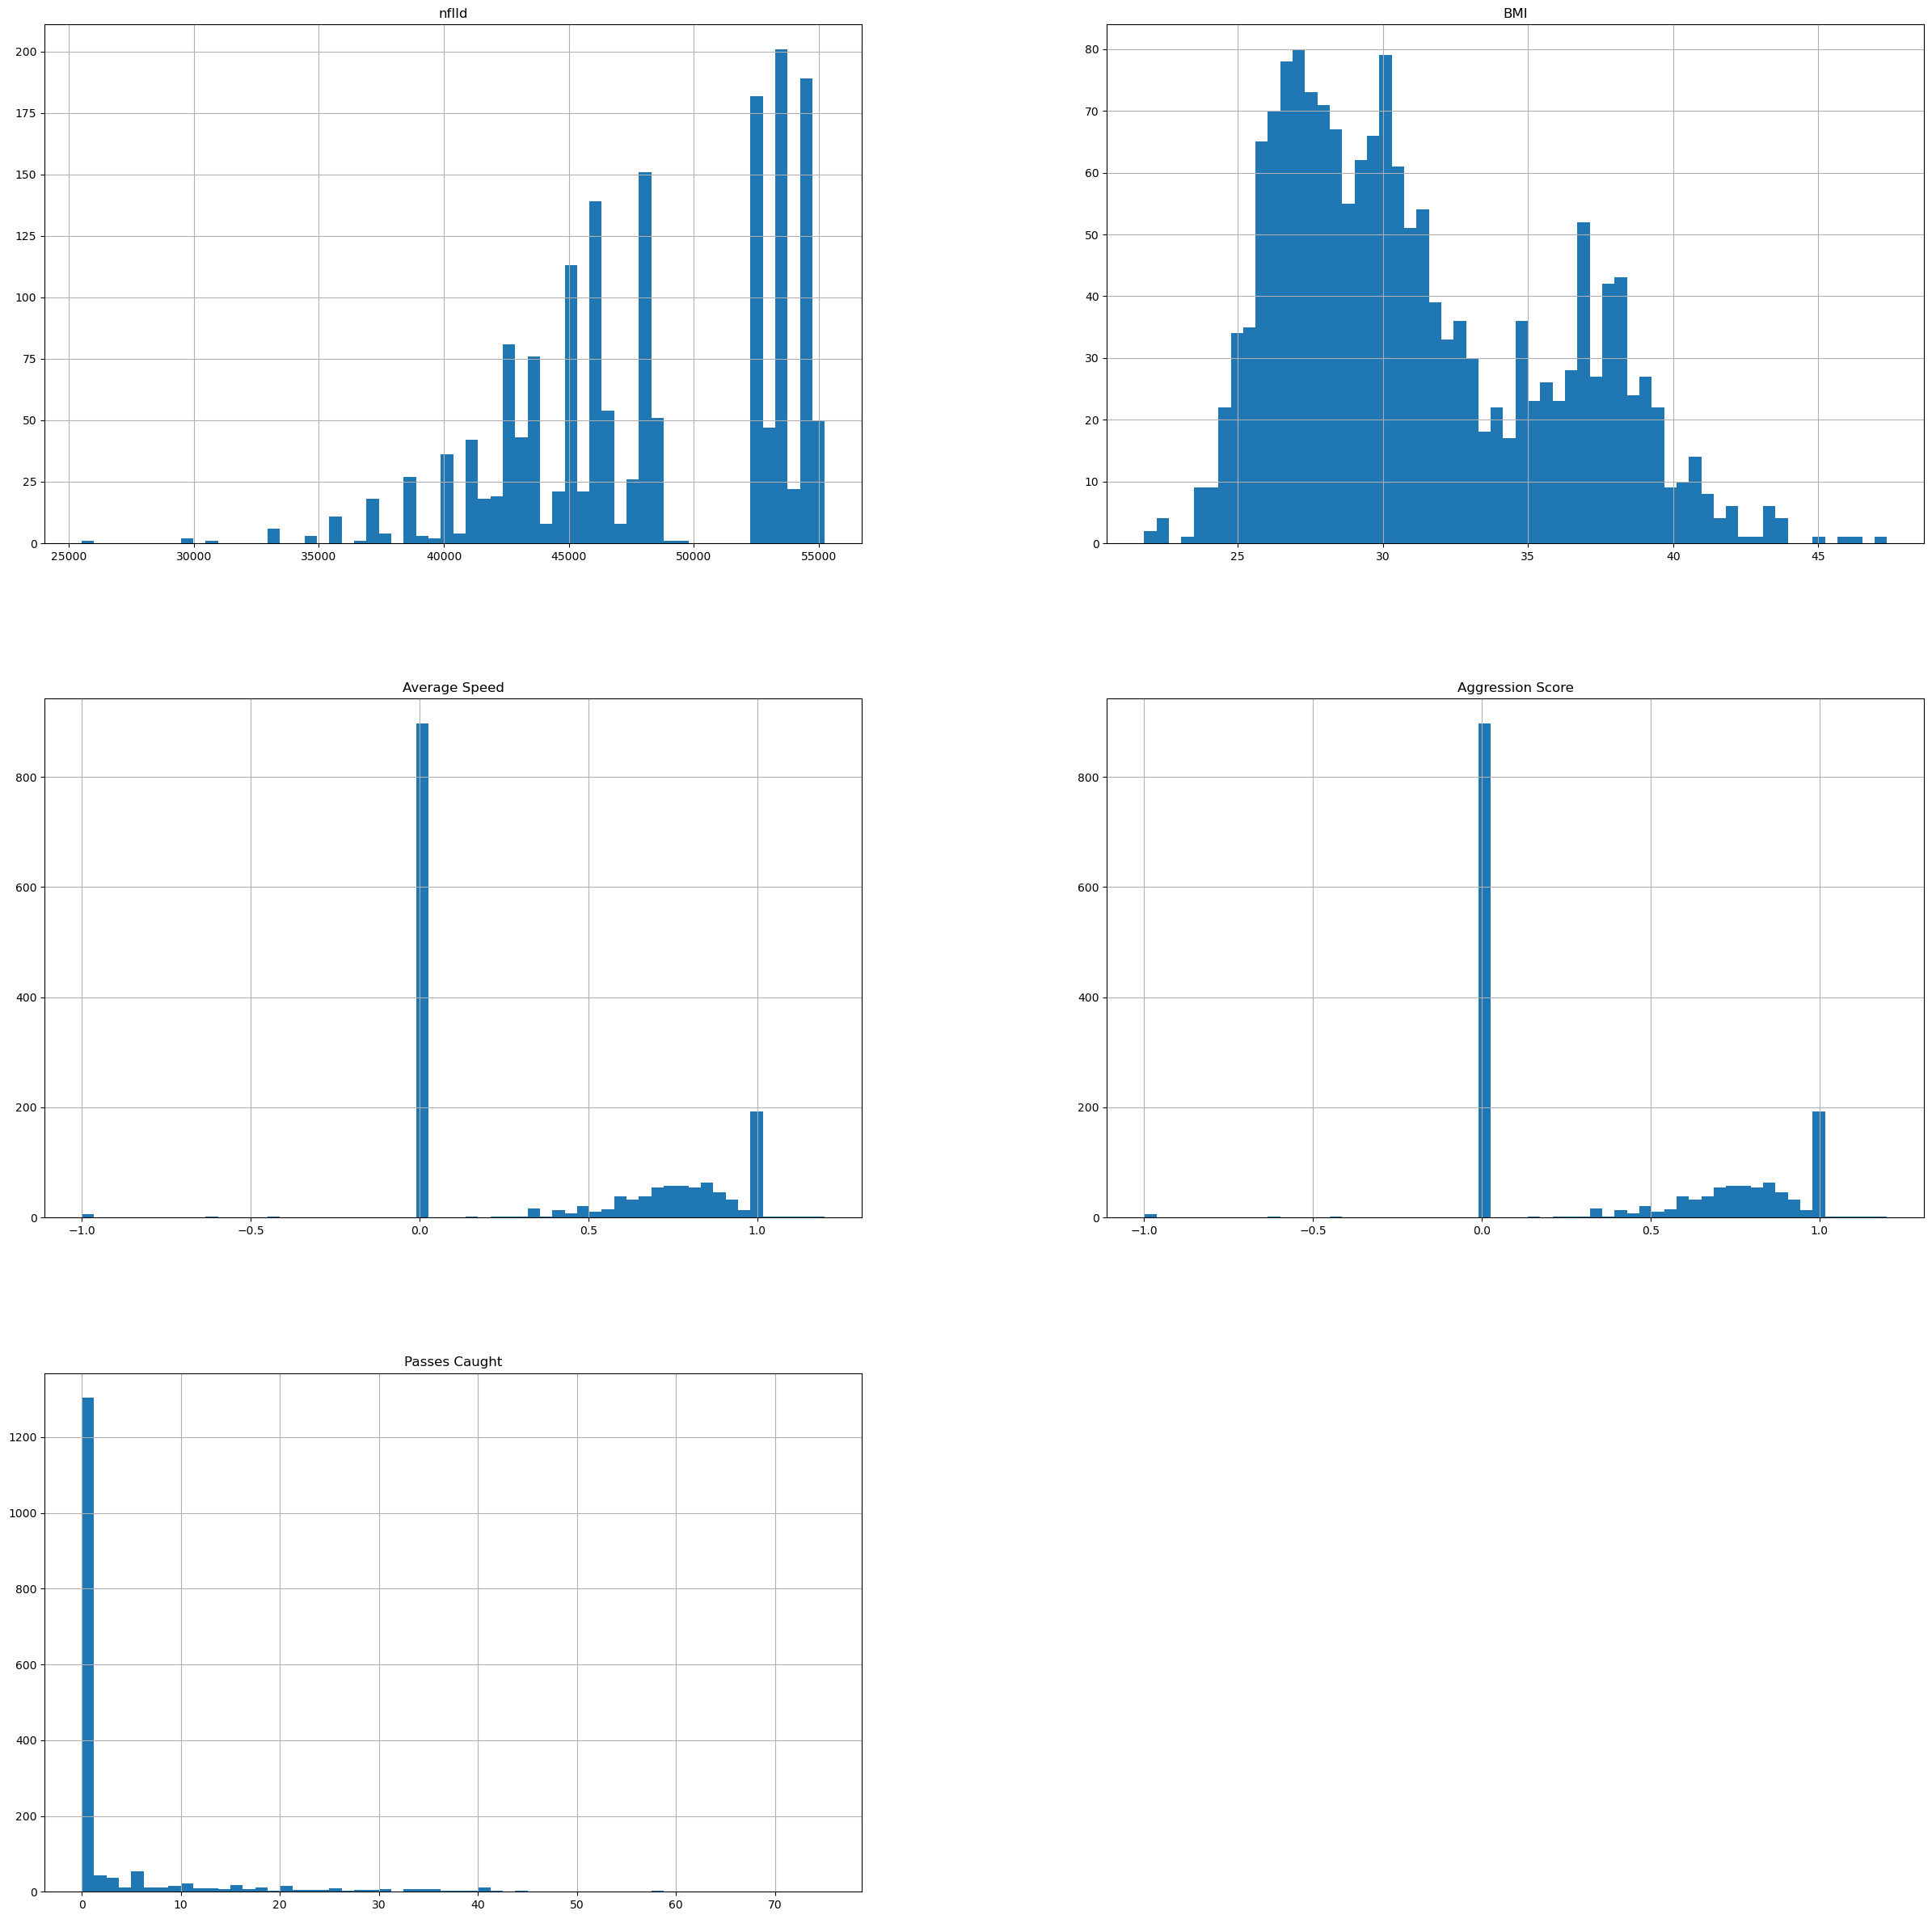

In [181]:
feature_table.hist(bins=60, figsize=[30,30])

In [182]:
feature_table['Position'].value_counts()

Position
WR        218
CB        192
DT        158
OLB       140
RB        138
TE        126
DE-OLB    125
T         121
G         103
LB         93
FS         78
S          64
QB         61
C-G        55
MLB        11
Name: count, dtype: int64

In [184]:
players_data['position'].value_counts()

position
WR        218
CB        192
DT        158
OLB       140
RB        138
TE        126
DE-OLB    125
T         121
G         103
LB         93
FS         78
S          64
QB         61
C-G        55
MLB        11
Name: count, dtype: int64

# Below this line is all Chat GPT Starter Code

In [67]:
def count_passes_caught(play_data, ball_carrier_id, pass_result='C'):
    # Filter play data for completed passes where the specified player is the ball carrier
    player_passes_caught = play_data[(play_data['ballCarrierId'] == ball_carrier_id) & (play_data['passResult'] == pass_result)]

    # Count the number of passes caught
    num_passes_caught = len(player_passes_caught)

    return num_passes_caught

# Example usage:
# Assuming you have loaded the play data into a DataFrame named 'plays_data'

# Replace 'your_ballCarrierId_here' with the actual ballCarrierId of the player you want to analyze
ballCarrierId_to_analyze = 33130	  

passes_caught = count_passes_caught(plays_data, ballCarrierId_to_analyze)
print(f"Number of passes caught by player with ballCarrierId {ballCarrierId_to_analyze}: {passes_caught}")


Number of passes caught by player with ballCarrierId 33130: 2


In [49]:
def calculate_average_time_per_game(play_data, tracking_data, ball_carrier_id):
    # Filter play data for plays where the specified player is the ball carrier
    player_plays = play_data[play_data['ballCarrierId'] == ball_carrier_id]

    if len(player_plays) == 0:
        print(f"Player with nflId {ball_carrier_id} not found in the play data.")
        return None

    # Merge play data with tracking data to get the corresponding gameId and playId
    merged_data = pd.merge(player_plays[['gameId', 'playId']], tracking_data, on=['gameId', 'playId'], how='inner')

    # Calculate the average time the player carries the ball per game
    average_time_per_game = merged_data.groupby('gameId')['time'].max().mean()

    return average_time_per_game

# Example usage:
# Assuming you have loaded the play data into a DataFrame named 'plays_data'
# and the tracking data into a DataFrame named 'tracking_data'

# Replace 'your_nflId_here' with the actual nflId of the player you want to analyze
nflId_to_analyze_average_time = 33130

average_time_per_game = calculate_average_time_per_game(plays_data, tracking_data_all_weeks, nflId_to_analyze_average_time)
if average_time_per_game is not None:
    print(f"Average time per game for player with nflId {nflId_to_analyze_average_time}: {average_time_per_game:.2f} seconds")


TypeError: Could not convert string '2022-11-07 21:08:32.799999' to numeric

In [42]:
def count_passes_thrown(play_data, passer_id):
    # Filter play data for passes thrown where the specified player is the passer
    player_passes_thrown = play_data[(play_data['passResult'] == 'C') & (play_data['passer_player_id'] == passer_id)]

    # Count the number of passes thrown
    num_passes_thrown = len(player_passes_thrown)

    return num_passes_thrown

# Example usage:
# Assuming you have loaded the play data into a DataFrame named 'plays_data'

# Replace 'your_passerId_here' with the actual passer_player_id of the player you want to analyze
passerId_to_analyze_passes_thrown = 25511	  

passes_thrown_count = count_passes_thrown(plays_data, passerId_to_analyze_passes_thrown)
print(f"Number of passes thrown by player with passer_player_id {passerId_to_analyze_passes_thrown}: {passes_thrown_count}")


KeyError: 'passer_player_id'